In [1]:
# import/load/test model

In [7]:
import os
import requests
from PIL import Image
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

In [16]:
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64")

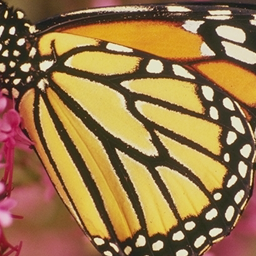

In [17]:
url = "https://huggingface.co/spaces/jjourney1125/swin2sr/resolve/main/samples/butterfly.jpg"

image = Image.open(requests.get(url, stream=True).raw)
image

In [18]:
processor = Swin2SRImageProcessor()
pixel_values = processor(image, do_pad=False, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 256, 256])


In [19]:
with torch.no_grad():
  outputs = model(pixel_values)
outputs.reconstruction.shape

torch.Size([1, 3, 1024, 1024])

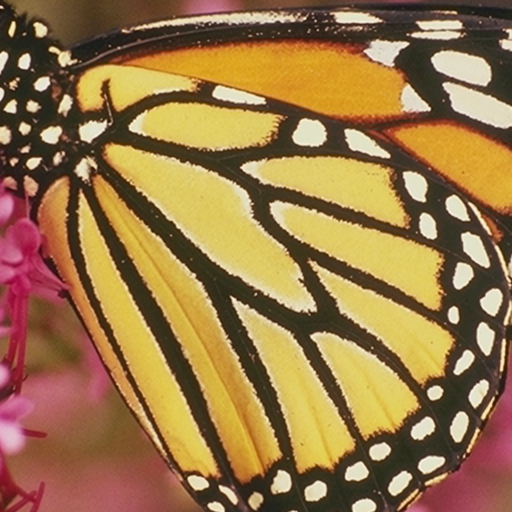

In [7]:
output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.moveaxis(output, source=0, destination=-1)
output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
Image.fromarray(output)

In [21]:
# Get perf eval on the dataset before fine tuning

In [16]:
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64") # Note: x4 model not x2
processor = Swin2SRImageProcessor()
model.eval()

def upscale_image(image_path):
    # print("Upscaling " + str(image_path))
    image = Image.open(image_path)
    pixel_values = processor(image, do_pad=False, return_tensors="pt").pixel_values

    # print(pixel_values.size())

    with torch.no_grad():
        outputs = model(pixel_values)

    # print(outputs.reconstruction.shape)

    output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy() # normalizes
    output = np.moveaxis(output, source=0, destination=-1) # color channel axes change
    output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
    return output # np arr
    # return Image.fromarray(output) # image

In [18]:
lr_dir = "test_set/LR"
hr_dir = "test_set/HR"

filenames, psnr_values, ssim_values = [], [], []

image_extensions = [ ".png" ]

for index, filename in enumerate(os.listdir(lr_dir)):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        lr_image_path = os.path.join(lr_dir, filename)
        hr_image_path = os.path.join(hr_dir, filename)

        # Check if the corresponding HR image exists
        if os.path.exists(hr_image_path):
            try:
                # Upscale the LR image
                upscaled_image = upscale_image(lr_image_path)
                # print(f"SR Image Size: {upscaled_image.size}")

                # Load the HR image
                hr_image = Image.open(hr_image_path)
                
                # print(f"HR Image Size: {processed_hr_image.size()}")

                # already an np arr
                # upscaled_image_np = np.array(upscaled_image)

                hr_image_np = np.array(hr_image)

                psnr = compare_psnr(hr_image_np, upscaled_image, data_range=255)
                ssim = compare_ssim(hr_image_np, upscaled_image, multichannel=True, channel_axis=-1)

                print(hr_image_path, psnr, ssim)
                
                filenames.append(filename)
                psnr_values.append(psnr)
                ssim_values.append(ssim)
            except UnidentifiedImageError:
                print(f"Skipped file (not an image): {filename}")
        else:
            print("No HR image exists for " + str(filename))

    print("index: " + str(index))

base_model_results = pd.DataFrame({'Filename': filenames, 'PSNR': psnr_values, 'SSIM': ssim_values})
base_model_results.to_csv("base_model_results.csv", index=False)

test_set/HR/00867.png 35.26336629732109 0.8634281370783757
index: 0
test_set/HR/00873.png 37.23392598903405 0.9228479827143156
index: 1
test_set/HR/00898.png 36.806014384726566 0.9309084360274992
index: 2
test_set/HR/00913.png 33.595326670596606 0.9010692058735058
index: 3
test_set/HR/00907.png 37.38942338437375 0.9434802741934468
index: 4
test_set/HR/00906.png 39.6782214337052 0.9547991829571535
index: 5
test_set/HR/00912.png 35.49642862026189 0.8960745797984502
index: 6
test_set/HR/00899.png 34.059527626928116 0.9404192362783025
index: 7
test_set/HR/00872.png 31.56524595562611 0.8925406200883593
index: 8
test_set/HR/00866.png 30.646212863634936 0.8786719936755784
index: 9
test_set/HR/00858.png 33.93196174570565 0.9414662474569759
index: 10
test_set/HR/00870.png 38.08065937207531 0.9536108657735776
index: 11
test_set/HR/00864.png 33.26096011333677 0.9043026924480572
index: 12
test_set/HR/00938.png 37.361668721901324 0.9320563867607247
index: 13
test_set/HR/00904.png 36.17449923294557 

In [19]:
base_model_results.describe()

,PSNR,SSIM
count,200.000000,200.000000
mean,35.525717,0.918378
std,2.449843,0.026852
min,28.034384,0.827867
25%,33.940667,0.898960
50%,35.728992,0.922077
75%,37.271819,0.939801
max,40.887318,0.968487


In [34]:
print(base_model_results["SSIM"].describe())

0.9183777355550614
35.52571653642037
count    200.000000
mean       0.918378
std        0.026852
min        0.827867
25%        0.898960
50%        0.922077
75%        0.939801
max        0.968487
Name: SSIM, dtype: float64


In [35]:
print(base_model_results["PSNR"].describe())

count    200.000000
mean      35.525717
std        2.449843
min       28.034384
25%       33.940667
50%       35.728992
75%       37.271819
max       40.887318
Name: PSNR, dtype: float64


In [ ]:
# Fine tuning the model

In [3]:
# Dataset class
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.images = os.listdir(lr_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.images[idx])

        lr_image = Image.open(lr_image_path)
        hr_image = Image.open(hr_image_path)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [4]:
# Prepare dataset and dataloader
lr_dir = "train_set/LR"
hr_dir = "train_set/HR"
transform = transforms.Compose([transforms.ToTensor()])

dataset = SuperResolutionDataset(lr_dir, hr_dir, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [5]:
fine_tuned_model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64")
fine_tuned_model.train()

Swin2SRForImageSuperResolution(
  (swin2sr): Swin2SRModel(
    (first_convolution): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (embeddings): Swin2SREmbeddings(
      (patch_embeddings): Swin2SRPatchEmbeddings(
        (projection): Conv2d(180, 180, kernel_size=(1, 1), stride=(1, 1))
        (layernorm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swin2SREncoder(
      (stages): ModuleList(
        (0-5): 6 x Swin2SRStage(
          (layers): ModuleList(
            (0-5): 6 x Swin2SRLayer(
              (attention): Swin2SRAttention(
                (self): Swin2SRSelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (que

In [6]:
# Optimizer and loss
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

# Training loop
num_epochs = 1  # Define the number of epochs
save_interval = 5  # Save every 2 epochs

all_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        lr_images, hr_images = data
        optimizer.zero_grad()

        # Generate SR images
        outputs = fine_tuned_model(lr_images)
        sr_images = outputs.reconstruction

        # Compute loss and backprop
        loss = criterion(sr_images, hr_images)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Store the loss for this batch
        all_losses.append({'epoch': epoch+1, 'batch': i+1, 'loss': batch_loss})

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

    # Save the model
    if (epoch + 1) % save_interval == 0:
        torch.save(fine_tuned_model.state_dict(), f"swin2sr_epoch_{epoch+1}.pth")

torch.save(fine_tuned_model.state_dict(), f"swin2sr_fine_tuned_FINAL.pth")



df_losses = pd.DataFrame(all_losses)
# print(df_losses)


df_losses.to_csv("training_losses.csv", index=False)

print("Training complete")

: 

: 

In [ ]:
# See what's up with the fine tuned model

In [4]:
training_losses = pd.read_csv("training_losses.csv")
training_losses.head()

,epoch,batch,loss
0,1,1,0.000214
1,1,2,0.000142
2,1,3,0.000133
3,1,4,0.000174
4,1,5,0.000239


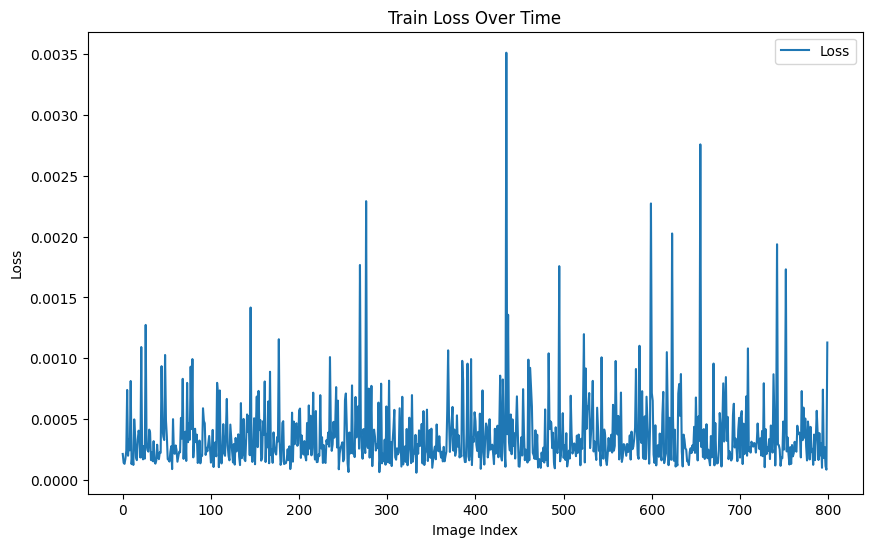

In [31]:
# training_losses.plot(y="loss")

plt.figure(figsize=(10,6))
plt.plot(training_losses["loss"], label='Loss')
plt.title('Train Loss Over Time')
plt.xlabel('Image Index')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# This doesn't look amazing...

In [9]:
# Eval the fine tuned model
fine_tuned_model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64")

model_path = "swin2sr_fine_tuned_FINAL.pth"

fine_tuned_model.load_state_dict(torch.load(model_path))


fine_tuned_model.eval()

Swin2SRForImageSuperResolution(
  (swin2sr): Swin2SRModel(
    (first_convolution): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (embeddings): Swin2SREmbeddings(
      (patch_embeddings): Swin2SRPatchEmbeddings(
        (projection): Conv2d(180, 180, kernel_size=(1, 1), stride=(1, 1))
        (layernorm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swin2SREncoder(
      (stages): ModuleList(
        (0-5): 6 x Swin2SRStage(
          (layers): ModuleList(
            (0-5): 6 x Swin2SRLayer(
              (attention): Swin2SRAttention(
                (self): Swin2SRSelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (que

In [10]:
processor = Swin2SRImageProcessor()

def upscale_image_fine_tuned(image_path):
    # print("Upscaling " + str(image_path))
    image = Image.open(image_path)
    pixel_values = processor(image, do_pad=False, return_tensors="pt").pixel_values

    # print(pixel_values.size())

    with torch.no_grad():
        outputs = fine_tuned_model(pixel_values)

    # print(outputs.reconstruction.shape)

    output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy() # normalizes
    output = np.moveaxis(output, source=0, destination=-1) # color channel axes change
    output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
    return output # np arr
    # return Image.fromarray(output) # image

In [12]:
lr_dir = "test_set/LR"
hr_dir = "test_set/HR"

filenames, psnr_values, ssim_values = [], [], []

image_extensions = [ ".png" ]

for index, filename in enumerate(os.listdir(lr_dir)):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        lr_image_path = os.path.join(lr_dir, filename)
        hr_image_path = os.path.join(hr_dir, filename)

        # Check if the corresponding HR image exists
        if os.path.exists(hr_image_path):
            try:
                # Upscale the LR image w/ fine tuned model
                upscaled_image = upscale_image_fine_tuned(lr_image_path)
                # print(f"SR Image Size: {upscaled_image.size}")

                # Load the HR image
                hr_image = Image.open(hr_image_path)
                
                # print(f"HR Image Size: {processed_hr_image.size()}")

                # already an np arr
                # upscaled_image_np = np.array(upscaled_image)

                hr_image_np = np.array(hr_image)

                psnr = compare_psnr(hr_image_np, upscaled_image, data_range=255)
                ssim = compare_ssim(hr_image_np, upscaled_image, multichannel=True, channel_axis=-1)

                print(hr_image_path, psnr, ssim)
                
                filenames.append(filename)
                psnr_values.append(psnr)
                ssim_values.append(ssim)
            except UnidentifiedImageError:
                print(f"Skipped file (not an image): {filename}")
        else:
            print("No HR image exists for " + str(filename))

    print("index: " + str(index))

fine_tuned_model_results = pd.DataFrame({'Filename': filenames, 'PSNR': psnr_values, 'SSIM': ssim_values})
fine_tuned_model_results.to_csv("fine_tuned_model_results.csv", index=False)

test_set/HR/00867.png 35.25699808194846 0.863704657292737
index: 0
test_set/HR/00873.png 37.22492098883217 0.9228507932433669
index: 1
test_set/HR/00898.png 36.75305778801232 0.9304378109621898
index: 2
test_set/HR/00913.png 33.571104504539676 0.9004654375723664
index: 3
test_set/HR/00907.png 37.346132915735666 0.9432179978411964
index: 4
test_set/HR/00906.png 39.633813458097464 0.9544537636279822
index: 5
test_set/HR/00912.png 35.46195702430765 0.8958376174559882
index: 6
test_set/HR/00899.png 34.05645217251004 0.9403167034968539
index: 7
test_set/HR/00872.png 31.55775873806624 0.8922129321117311
index: 8
test_set/HR/00866.png 30.573090226515575 0.876731760242866
index: 9
test_set/HR/00858.png 34.0234129765135 0.940906056865802
index: 10
test_set/HR/00870.png 38.015444744051415 0.9533640054902701
index: 11
test_set/HR/00864.png 33.16514333429661 0.9033983827625233
index: 12
test_set/HR/00938.png 37.35033976022837 0.9320552210295071
index: 13
test_set/HR/00904.png 36.15125496556351 0.9

In [13]:
fine_tuned_model_results.describe()

,PSNR,SSIM
count,200.000000,200.000000
mean,35.478706,0.917822
std,2.443826,0.026935
min,27.982216,0.826058
25%,33.964060,0.898559
50%,35.705102,0.921694
75%,37.226005,0.938966
max,40.719560,0.967950


In [27]:
# let's compare
base_model_stats = base_model_results.describe()
fine_tuned_model_stats = fine_tuned_model_results.describe()
print(base_model_stats)
print(fine_tuned_model_stats)

             PSNR        SSIM
count  200.000000  200.000000
mean    35.525717    0.918378
std      2.449843    0.026852
min     28.034384    0.827867
25%     33.940667    0.898960
50%     35.728992    0.922077
75%     37.271819    0.939801
max     40.887318    0.968487
             PSNR        SSIM
count  200.000000  200.000000
mean    35.478706    0.917822
std      2.443826    0.026935
min     27.982216    0.826058
25%     33.964060    0.898559
50%     35.705102    0.921694
75%     37.226005    0.938966
max     40.719560    0.967950


In [29]:
diff_stats = fine_tuned_model_stats - base_model_stats
print(diff_stats)

           PSNR      SSIM
count  0.000000  0.000000
mean  -0.047010 -0.000556
std   -0.006018  0.000083
min   -0.052168 -0.001810
25%    0.023394 -0.000400
50%   -0.023891 -0.000383
75%   -0.045814 -0.000835
max   -0.167758 -0.000537


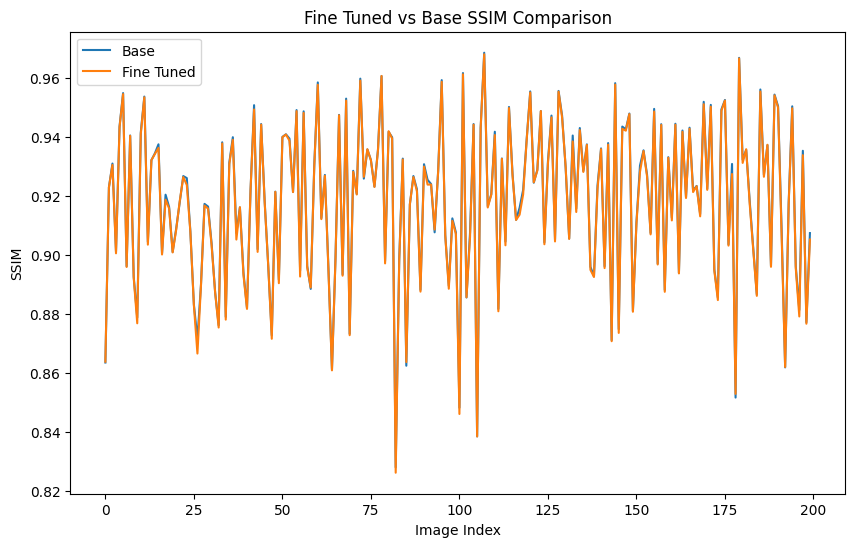

In [33]:
plt.figure(figsize=(10,6))
plt.plot(base_model_results["SSIM"], label='Base')
plt.plot(fine_tuned_model_results["SSIM"], label='Fine Tuned')
plt.title('Fine Tuned vs Base SSIM Comparison')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.legend()
plt.show()

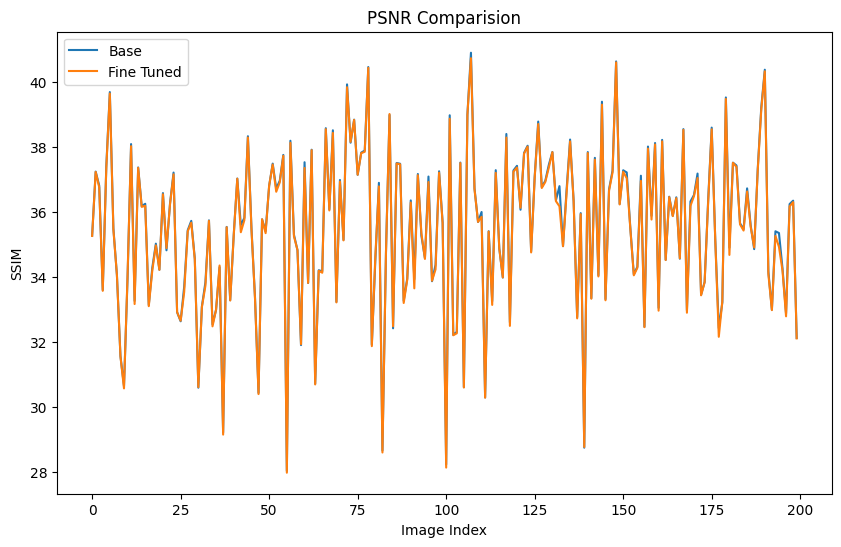

In [26]:
plt.figure(figsize=(10,6))
plt.plot(base_model_results["PSNR"], label='Base')
plt.plot(fine_tuned_model_results["PSNR"], label='Fine Tuned')
plt.title('PSNR Comparision')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.legend()
plt.show()